In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 

In [4]:
def categorise_age(age):
    if age <= 19:
        return "Paediatric"
    elif 20 <= age <= 39:
        return "Young Adult"
    elif 40 <= age <= 64:
        return "Adult"
    else:
        return "Elderly"

X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_31373/2568762353.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)


In [5]:
gender_mapping = {0 : 'Male', 1 : 'Female'}

X['Gender'] = X['Gender'].map(gender_mapping)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_31373/1515168427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gender'] = X['Gender'].map(gender_mapping)


In [6]:
X['demographic'] = X['Gender'] + ', ' + X['Race'] + ', ' + X['Age_class_at_diagnosis']
X.drop(columns = ["Age_class_at_diagnosis", "Gender", "Race", "Age_at_diagnosis"], inplace = True)

In [7]:
demo_mapping = {
 'male, white, paediatric': 1,
 'male, black or african american, paediatric': 2,
 'male, asian, paediatric': 3,
 'male, american indian or alaska native, paediatric': 4,
 'male, white, young adult': 5,
 'male, black or african american, young adult': 6,
 'male, asian, young adult': 7,
 'male, american indian or alaska native, young adult': 8,
 'male, white, adult': 9,
 'male, black or african american, adult': 10,
 'male, asian, adult': 11,
 'male, american indian or alaska native, adult': 12,
 'male, white, elderly': 13,
 'male, black or african american, elderly': 14,
 'male, asian, elderly': 15,
 'male, american indian or alaska native, elderly': 16,
 'female, white, paediatric': 17,
 'female, black or african american, paediatric': 18,
 'female, asian, paediatric': 19,
 'female, american indian or alaska native, paediatric': 20,
 'female, white, young adult': 21,
 'female, black or african american, young adult': 22,
 'female, asian, young adult': 23,
 'female, american indian or alaska native, young adult': 24,
 'female, white, adult': 25,
 'female, black or african american, adult': 26,
 'female, asian, adult': 27,
 'female, american indian or alaska native, adult': 28,
 'female, white, elderly': 29,
 'female, black or african american, elderly': 30,
 'female, asian, elderly': 31,
 'female, american indian or alaska native, elderly': 32
}



X['demographic'] = X['demographic'].str.lower().map(demo_mapping)

## IW

In [9]:
## Extract demographic column
demographic = X['demographic']

In [10]:
# Extract features (excluding demographic and Grading)
mutations_grading = X.drop(columns=['demographic'])

In [11]:
def assign_inverse_frequency_weights(df, group_col):
    """
    Assigns weights to each row in the dataframe inversely proportional
    to the frequency of its group in `group_col`.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column name representing demographic groups.

    Returns:
        pd.DataFrame: Original DataFrame with new 'weight' column added.
    """
    group_counts = df[group_col].value_counts()
    weights = df[group_col].map(lambda x: 1 / group_counts[x])
    weights = weights / weights.sum()  # Normalize weights to sum to 1 (optional)
    df = df.copy()
    df['weight'] = weights
    return df

In [12]:
# Apply weighting
df_weighted = assign_inverse_frequency_weights(X, 'demographic')

## Feature selection without White race

In [15]:
df_weighted_no_white = df_weighted[~df_weighted['demographic'].isin([1, 5, 9, 13, 17, 21, 25, 29])]

In [16]:
# Replace with your actual feature columns
X_no_white = df_weighted_no_white.drop(columns = ['weight'])
weights_no_white = df_weighted_no_white['weight']
y_no_white = y[y.index.isin(X_no_white.index)]

In [17]:
# Train/test split
X_train_no_white, X_test_no_white, y_train_no_white, y_test_no_white, w_train_no_white, w_test_no_white = train_test_split(
    X_no_white, y_no_white, weights_no_white, test_size=0.10, random_state=1, stratify=y_no_white
)


X_train_no_white, X_val_no_white, y_train_no_white, y_val_no_white, w_train_no_white, w_val_no_white = train_test_split(
    X_train_no_white, y_train_no_white, w_train_no_white, test_size=0.25, random_state=1, stratify=y_train_no_white
)

## Feature selection

In [31]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

def mrmr_feature_selection(X, y, n_features, random_state=1):
    """Performs mRMR feature selection (unweighted MI)."""
    np.random.seed(random_state)
    y = y.ravel()

    # Note: mutual_info_classif does not support sample weights directly
    mi = mutual_info_classif(X, y, random_state=random_state)
    selected = []
    remaining = list(range(X.shape[1]))

    # first pick
    first = np.argmax(mi)
    selected.append(first)
    remaining.remove(first)

    # iterative pick
    for _ in range(min(n_features - 1, len(remaining))):
        relevance = mi[remaining]
        # compute average redundancy
        red_vals = []
        for s in selected:
            for f in remaining:
                xf = X.iloc[:, f] if isinstance(X, pd.DataFrame) else X[:, f]
                xs = X.iloc[:, s] if isinstance(X, pd.DataFrame) else X[:, s]
                corr = np.corrcoef(xf, xs)[0,1]
                red_vals.append(corr)
        redundancy = np.nanmean(red_vals) if red_vals else 0
        scores = relevance - redundancy
        if len(scores) == 0:
            break
        nxt = remaining[np.argmax(scores)]
        selected.append(nxt)
        remaining.remove(nxt)

    return selected


def embedded_lasso_selection(X, y, sample_weight=None, random_state=1):
    """Performs feature selection using weighted LASSO regression."""
    np.random.seed(random_state)
    y = y.ravel()

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, max_iter=10000, random_state=random_state)
    # Pass sample_weight to respect IPW in both CV and penalty
    lasso.fit(Xs, y, sample_weight=sample_weight)

    return np.where(lasso.coef_ != 0)[0]


def mrmr_lasso_pipeline(X, y, ipw_weights=None, desired_n_features=13, buffer_mrmr=30, random_state=1):
    """
    Combines unweighted mRMR MI and weighted LASSO to select features.
    - ipw_weights: array-like of sample weights (inverse-probabilities)
    - desired_n_features: final number of features
    - buffer_mrmr: number of top mRMR features to feed into LASSO
    """
    np.random.seed(random_state)
    # flatten y
    y_arr = y.values.ravel() if hasattr(y, 'values') else y.ravel()

    # Step 1: mRMR (unweighted)
    top_mrmr = mrmr_feature_selection(X, y_arr, buffer_mrmr, random_state=random_state)
    X_mrmr = X.iloc[:, top_mrmr] if hasattr(X, 'iloc') else X[:, top_mrmr]

    # Step 2: weighted LASSO
    lasso_idx = embedded_lasso_selection(X_mrmr, y_arr, sample_weight=ipw_weights, random_state=random_state)
    final = [top_mrmr[i] for i in lasso_idx]

    # Step 3: ensure exact number of features
    if len(final) < desired_n_features:
        for feat in top_mrmr:
            if feat not in final:
                final.append(feat)
            if len(final) == desired_n_features:
                break
    else:
        final = final[:desired_n_features]

    return final

In [33]:
final_selected_features = mrmr_lasso_pipeline(X_train_no_white, y_train_no_white, ipw_weights = w_train_no_white, random_state = 1)

print("Selected Feature Indices:", final_selected_features)

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected Feature Indices: [4, 0, 15, 17, 18, 12, 1, 2, 3, 6, 7, 8, 11]


In [35]:
X = df_weighted.drop(columns = ['weight'])
weights = df_weighted['weight']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.10, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X_train, y_train, w_train, test_size=0.25, random_state=1, stratify=y_train
)


X_train = X_train.iloc[:, [4, 0, 15, 17, 18, 12, 1, 2, 3, 6, 7, 8, 11, 20]]

In [37]:
import xgboost as xgb
model = xgb.XGBClassifier(eval_metric='error')

# Define the parameter grid
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_val, y_val)

# Output best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
Best Score: 0.8298542967588461


In [38]:
model = xgb.XGBClassifier(eval_metric='error', colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 5, n_estimators = 200, subsample = 0.6)
model.fit(X_train, y_train)

# Make predictions
X_test = X_test.iloc[:, [4, 0, 15, 17, 18, 12, 1, 2, 3, 6, 7, 8, 11, 20]]
prediction = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy:.2f}")

sensitivity = recall_score(y_test, prediction)
print(f"Sensitivity: {sensitivity:.2f}")

Accuracy: 0.90
Sensitivity: 0.97


In [39]:
y_test = y_test.values

results_df = pd.DataFrame({
    'demographic': X_test['demographic'].values,
    'actual': y_test.ravel(),
    'predicted': prediction.ravel()
})


# Compute accuracy per demographic
accuracy_per_demo = results_df.groupby('demographic').apply(
    lambda x: accuracy_score(x['actual'], x['predicted'])
).reset_index()

sensitivity_per_demo = results_df.groupby('demographic').apply(
    lambda x: recall_score(x['actual'], x['predicted'])
).reset_index()

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
accuracy_per_demo.columns = ['Demographic', 'Accuracy']
accuracy_per_demo

,Demographic,Accuracy
0,1,1.000000
1,5,1.000000
2,9,0.875000
3,10,1.000000
4,13,0.900000
5,14,1.000000
6,21,0.818182
7,25,0.769231
8,29,1.000000
9,30,1.000000


In [41]:
sensitivity_per_demo.columns = ['Demographic', 'Sensitivity']
sensitivity_per_demo

,Demographic,Sensitivity
0,1,0.0
1,5,1.0
2,9,1.0
3,10,1.0
4,13,1.0
5,14,1.0
6,21,0.0
7,25,1.0
8,29,1.0
9,30,1.0


## ROC Curve

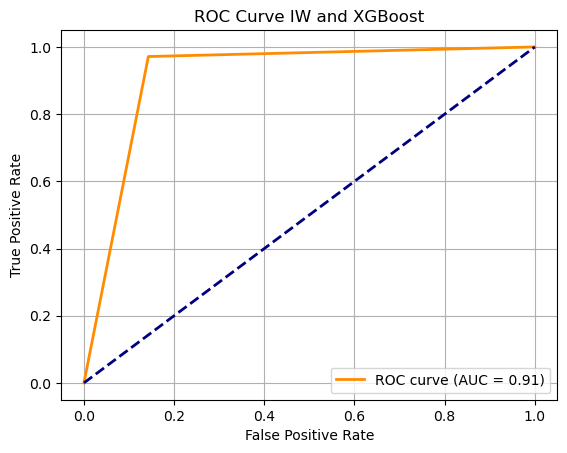

In [43]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(results_df['actual'], results_df['predicted'])

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve IW and XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [44]:
# Create an empty dictionary to hold the AUC for each demographic
auc_per_demo = {}

# Group by demographic and compute AUC for each group
for demo, group in results_df.groupby('demographic'):
    fpr, tpr, _ = roc_curve(group['actual'], group['predicted'])
    auc_score = auc(fpr, tpr)
    auc_per_demo[demo] = auc_score

# Optional: convert to a DataFrame
auc_per_demo_df = pd.DataFrame.from_dict(auc_per_demo, orient='index', columns=['AUC'])
auc_per_demo_df

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


,AUC
1,NaN
5,1.000000
9,0.833333
10,1.000000
13,0.833333
14,NaN
21,0.450000
25,0.863636
29,1.000000
30,NaN


## SHAP plot

model_output = "margin" has been renamed to model_output = "raw"
[14:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


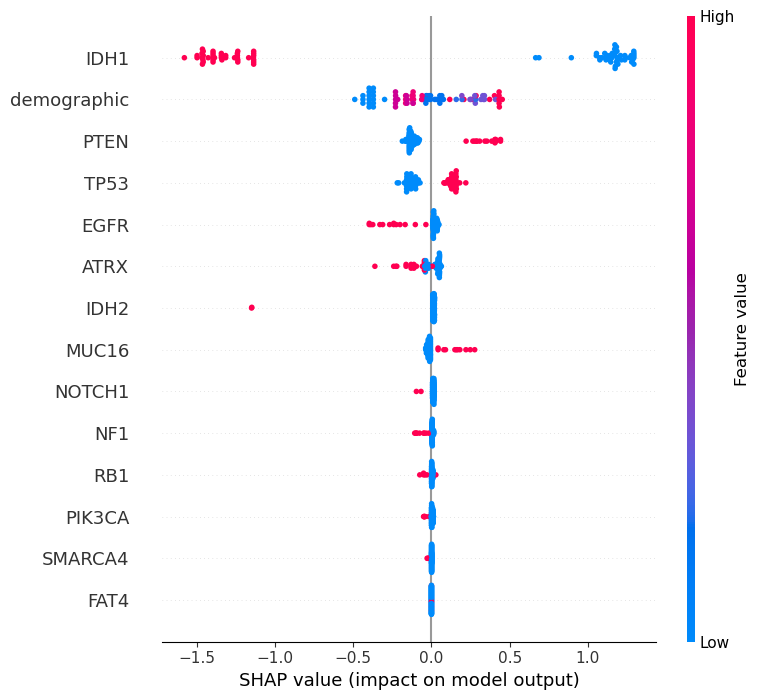

In [53]:
import shap

feature_names = X_train.columns.to_list()


explainer = shap.TreeExplainer(
    model, data=X_train, feature_perturbation="interventional", model_output="margin"
)

# SHAP values shape: (n_samples, n_features)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)